### Here, I will be trying to do some feature engineering. Using the data that we have, So that we can provide this to the agentic archi and itis able to understand it well.

In [1]:
%matplotlib inline

In [2]:
## Features that we have to work on 
{'what_you_see': ['Blinking', 'Gaze', 'Jaw', 'Smile'],
 'how_it_is_said': ['loudness', 'pitch_avg', 'pitch_var'],
 'What_is_said': ['filler%', 'pause%', 'words', 'words_rate']}

{'what_you_see': ['Blinking', 'Gaze', 'Jaw', 'Smile'],
 'how_it_is_said': ['loudness', 'pitch_avg', 'pitch_var'],
 'What_is_said': ['filler%', 'pause%', 'words', 'words_rate']}

In [3]:
import sys
import math
import json
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal, Optional, Union, Dict
from pathlib import Path

In [4]:
current_dir = Path.cwd()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print('done')

done


In [5]:
from src.utils.save_data import save_df_parquet_safe, load_df_parquet_safe
from src.utils.plot_graphs import plot_beautiful, plot_dual_beautiful

In [6]:
path = project_root / "data" / "processed" / "merge" / "avw_merged_2.parquet"
avw_data = load_df_parquet_safe(path=str(path))
avw_data_copy = avw_data.copy()
avw_data_copy.head()

,Time,words,text_concat,h_ratio,v_ratio,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,...,mouthUpperUpRight,noseSneerLeft,noseSneerRight,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent,speaker,filler_percentage,pause_percent_pr
0,0.0,"[We're, starting]",We're starting,0.463844,0.012997,3.112116e-06,0.015592,0.025971,0.023290,0.123947,...,0.000022,4.540787e-07,4.185384e-07,0.0373,0.00,0.00,False,None,0.064433,0.079177
1,0.5,"[now., [*]]",now. [*],0.418074,-0.048988,2.558370e-06,0.017408,0.037184,0.007811,0.137800,...,0.000030,2.511999e-07,3.643879e-07,0.0533,169.25,11.45,False,A,0.064433,0.079177
2,1.0,None,,0.465044,-0.030748,3.958608e-07,0.008864,0.010406,0.016732,0.179330,...,0.000269,2.899701e-06,1.134860e-07,0.0006,0.00,0.00,True,A,0.064433,0.079177
3,1.5,"[So, welcome]",So welcome,0.505119,-0.055033,3.260218e-07,0.012983,0.016629,0.008106,0.186212,...,0.000103,2.350217e-06,9.529118e-08,0.0593,179.94,14.03,False,A,0.064433,0.079177
4,2.0,"[to, the]",to the,0.590369,-0.050514,5.068692e-07,0.016363,0.028436,0.006705,0.117622,...,0.000476,4.304491e-06,2.317813e-07,0.0646,237.84,56.17,False,A,0.064433,0.079177


## Blinking

In [7]:
from pydantic import BaseModel, Field

In [8]:
# let's define some datamodels
class Blink(BaseModel):
    """Blinking metrics for single frame"""
    intensity: float = Field(..., ge=0.0, le=1.0, description="Average eye closure intensity (0=open, 1=closed)")
    asymmetry: float = Field(..., ge=0.0, le=1.0, description="Difference between left and right eye closure")
    is_blinking: bool = Field(..., description="True if eyes closed above threshold (>0.5)")

In [9]:
def blink_data(eyeblinkleft: float, eyeblinkright: float, eyesquintleft: float, eyesquintright: float, blinkweigth: float = 0.8, squintweigth: float = 0.2, mode: Literal["training", "evaluation"] = "training") -> Union[Blink, float]:
    """given the data this function returns Blink object that given info about the blinking of the user

    Args:
        eyeblinkleft (float): column: eyeBlinkLeft data
        eyeblinkright (float): column: eyeBlinkRight data
        eyesquintleft (float): column: eyeSquintLeft data
        eyesquintright (float): column: eyeSquintRight data
        blinkweigth (float, optional): weight on the blink. Defaults to 0.8.
        squintweigth (float, optional): weight on the squint. Defaults to 0.2.

    Returns:
        Blink: return Blink object or intensity of blink
    """
    left_closure = (eyeblinkleft * blinkweigth) + (eyesquintleft * squintweigth)
    right_closure = (eyeblinkright * blinkweigth) + (eyesquintright * squintweigth)
    
    avg_closure = (left_closure + right_closure)/2
    
    if mode == "training":
        return avg_closure
    else:
        is_closing = avg_closure > 0.5
        
        asymmetry = abs(left_closure - right_closure)
    
        blink = Blink(
            blinking=is_closing,
            asymmetry= asymmetry,
            intensity=avg_closure
        )
        return blink

## Gaze

In [10]:
class Gaze(BaseModel):
    """Gaze direction metrics for single frame"""
    horizontal_deviation: float = Field(..., description="Net horizontal deviation (-1=left, 0=center, 1=right)")
    vertical_deviation: float = Field(..., description="Net vertical deviation (-1=down, 0=center, 1=up)")
    primary_direction: Literal["center", "left", "right", "up", "down"] = Field(..., description="Primary gaze direction")

In [11]:
def gaze_data(h_ratio: float, eyelookupleft: float, eyelookupright: float, eyelookdownleft: float, eyelookdownright: float, h_center: float = 0.5, h_dead_zone: float = 0.08, v_threshold: float = 0.15, mode: Literal["training", "evaluation"] = "training") -> Union[Gaze, float]:
    """Gaze metrics for anomaly detection

    Args:
        h_ratio (float): 
        eyelookupleft (float): 
        eyelookupright (float): 
        eyeLookDownLeft (float): 
        eyelookdownright (float): 
        h_center (float, optional): Defaults to 0.5.
    
    Returns: Gaze object or gaze_magnitude
    """
    
    # horizontal deviation
    h_deviation = h_ratio - h_center
    
    # vertical metrics
    look_up = (eyelookupleft + eyelookupright)/2
    look_down = (eyelookdownleft + eyelookdownright)/2
    
    # Calculate intensities
    intensity_left = max(0.0, min(1.0, -h_deviation / 0.2))   
    intensity_right = max(0.0, min(1.0, h_deviation / 0.2))
    intensity_up = min(1.0, look_up / 0.6)
    intensity_down = min(1.0, look_down / 0.6)
    
    # Gaze magnitude (useful for anomaly detection)
    gaze_magnitude = (intensity_left + intensity_right + intensity_up + intensity_down)
    
    if mode == "training":
        return gaze_magnitude
    else:
        # Determine primary direction (priority: vertical > horizontal > center)
        if look_up > v_threshold:
            primary_direction = "up"
        elif look_down > v_threshold:
            primary_direction = "down"
        elif h_deviation < -(h_dead_zone):
            primary_direction = "left"
        elif h_deviation > h_dead_zone:
            primary_direction = "right"
        else:
            primary_direction = "center"
        gaze = Gaze(
            horizontal_deviation=h_deviation,
            vertical_deviation=look_up - look_down,
            primary_direction=primary_direction
        )
        return gaze

## Jaw

In [12]:
class Jaw(BaseModel):
    """Jaw movement metrics for single frame"""
    open: float = Field(..., ge=0.0, le=1.0, description="Jaw opening amount (0=closed, 1=fully open)")
    lateral: float = Field(..., ge=-1.0, le=1.0, description="Lateral jaw movement (-1=left, 0=center, 1=right)")
    forward: float = Field(..., ge=0.0, le=1.0, description="Forward jaw protrusion (0=normal, 1=fully forward)")
    magnitude: float = Field(..., ge=0.0, description="Total jaw movement (sum of absolute movements)")
    is_open: bool = Field(..., description="True if jaw open above threshold (>0.3)")

In [13]:
def jaw_data(jaw_open: float, jaw_left: float, jaw_right: float, jaw_forward: float, mode: Literal["training", "evaluation"] = "training") -> Union[Jaw, float]:
    """Jaw movement metrics for anomaly detection

    Args:
        jaw_open (float): 
        jaw_left (float): 
        jaw_right (float): 
        jaw_forword (float): 

    Returns:
        Union[Jaw, float]: jaw movement metrics or Jaw object
    """
    # Lateral movement
    jaw_lateral = jaw_right - jaw_left
    
    # Total jaw movement magnitude
    jaw_magnitude = jaw_open + abs(jaw_lateral) + jaw_forward
    
    if mode == "training":
        return jaw_magnitude
    else:
        jaw = Jaw(
            open=jaw_open,
            lateral=jaw_lateral,
            forward=jaw_forward,
            magnitude=jaw_magnitude,
            is_open=jaw_open > 0.3
        )
        return jaw

## Smile

In [14]:
class Smile(BaseModel):
    """Smile metrics for single frame"""
    intensity: float = Field(..., ge=0.0, le=1.0, description="Overall smile intensity (0=neutral, 1=full smile)")
    asymmetry: float = Field(..., ge=0.0, le=1.0, description="Difference between left and right smile")
    left_intensity: float = Field(..., ge=0.0, le=1.0, description="Left side smile intensity")
    right_intensity: float = Field(..., ge=0.0, le=1.0, description="Right side smile intensity")
    mouth_stretch: float = Field(..., ge=0.0, le=1.0, description="Mouth stretching/width (wider smile)")
    is_smiling: bool = Field(..., description="True if smiling above threshold (>0.3)")

In [15]:
def smile_data(mouthsmileleft: float, mouthsmileright: float, cheeksquintleft: float, cheeksquintright: float, mouthstretchleft: float, mouthstretchright: float, smile_weight: float = 0.7, squint_weight: float = 0.3, mode: Literal["training", "evaluation"] = "training") -> Union[Smile, float]:
    """Smile metrics for anomaly detection

    Args:
        mouthsmileleft (float): 
        mouthsmileright (float): 
        cheeksquintleft (float): 
        cheeksquintright (float): 
        mouthstretchleft (float): 
        mouthstretchright (float):
        smile_weight (float, optional): Defaults to 0.7.
        squint_weight (float, optional): Defaults to 0.3.

    Returns:
        Union[Smile, float]: smile intensity or Smile onject
    """
    
    # combined smile
    smile_left = mouthsmileleft * smile_weight + cheeksquintleft * squint_weight
    smile_right = mouthsmileright * smile_weight + cheeksquintright * squint_weight
    
    # intensity and asymmetry
    smile_intensity = (smile_left + smile_right )/2
    smile_asymmetry = abs(smile_left - smile_right)
    
    # mouth_stretch
    mouth_stretch = (mouthstretchleft + mouthsmileright)/2
    
    if mode == "training":
        return smile_intensity
    else:
        smile = Smile(
            intensity=smile_intensity,
            asymmetry=smile_asymmetry,
            left_intensity=smile_left,
            right_intensity=smile_right,
            mouth_stretch=mouth_stretch,
            is_smiling=smile_intensity > 0.3
        )
    return smile

## Audio

In [16]:
avw_data_copy.head()

,Time,words,text_concat,h_ratio,v_ratio,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,...,mouthUpperUpRight,noseSneerLeft,noseSneerRight,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent,speaker,filler_percentage,pause_percent_pr
0,0.0,"[We're, starting]",We're starting,0.463844,0.012997,3.112116e-06,0.015592,0.025971,0.023290,0.123947,...,0.000022,4.540787e-07,4.185384e-07,0.0373,0.00,0.00,False,None,0.064433,0.079177
1,0.5,"[now., [*]]",now. [*],0.418074,-0.048988,2.558370e-06,0.017408,0.037184,0.007811,0.137800,...,0.000030,2.511999e-07,3.643879e-07,0.0533,169.25,11.45,False,A,0.064433,0.079177
2,1.0,None,,0.465044,-0.030748,3.958608e-07,0.008864,0.010406,0.016732,0.179330,...,0.000269,2.899701e-06,1.134860e-07,0.0006,0.00,0.00,True,A,0.064433,0.079177
3,1.5,"[So, welcome]",So welcome,0.505119,-0.055033,3.260218e-07,0.012983,0.016629,0.008106,0.186212,...,0.000103,2.350217e-06,9.529118e-08,0.0593,179.94,14.03,False,A,0.064433,0.079177
4,2.0,"[to, the]",to the,0.590369,-0.050514,5.068692e-07,0.016363,0.028436,0.006705,0.117622,...,0.000476,4.304491e-06,2.317813e-07,0.0646,237.84,56.17,False,A,0.064433,0.079177


In [17]:
def compute_speaker_median_pitch(
    audio_path: str,
    speaker_segments: list,
    sr: int = 16000,
    fmin: float = 50.0,
    fmax: float = 600.0
):
    # loading the audio
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Extracting pitch
    f0, voiced_flag, _ = librosa.pyin(
        y,
        fmin=fmin,
        fmax=fmax,
        sr=sr
    )
    
    # Frame timestamps
    times = librosa.times_like(f0, sr=sr)
    pitches = []
    
    for seg in speaker_segments:
        start, end = seg
        
        mask = (times >= start) & (times <= end)
        voiced_f0 = f0[mask]
        voiced_f0 = voiced_f0[~np.isnan(voiced_f0)]
        
        pitches.extend(voiced_f0.tolist())
        
    return round(float(np.median(pitches)) if pitches else None, 2)

In [18]:
times = avw_data_copy[["Time", "speaker"]]

In [19]:
times

,Time,speaker
0,0.0,None
1,0.5,A
2,1.0,A
3,1.5,A
4,2.0,A
...,...,...
1259,629.5,A
1260,630.0,A
1261,630.5,A
1262,631.0,A


In [20]:
ss = times[~times['speaker'].isnull()].iloc[0]
ss = tuple(ss)
start_time, speaker = ss[0].item(), ss[1]
timings = []
for row in times.iterrows():
    row = tuple(row[1])
    if row[1] == None:
        continue
    elif (row[1] != speaker):
        timings.append({speaker: (start_time, row[0])})
        start_time = row[0]
        speaker = row[1]
        
timings.append({speaker: (start_time, row[0])})

In [21]:
list(timings[0].keys())

['A']

In [22]:
user_timings = [value for dic in timings for key, value in dic.items() if key == "B"]
user_timings

[(11.5, 140.0), (163.5, 288.5), (318.0, 604.0)]

In [23]:
path = project_root / "data" / "raw" / "Interview_2.wav"
results = compute_speaker_median_pitch(audio_path=str(path), speaker_segments=user_timings)

In [24]:
results

158.74

In [25]:
def audio_metrics_from_raw(
    audio_rms: float,
    pitch_avg_hz: float,
    pitch_var_hz2: float,
    speaker_median_pitch_hz: Optional[float] = None,
    eps: float = 1e-9
) -> Dict[str, float | bool | str]:
    """
    Convert raw audio features into interpretable metrics.

    Args:
        audio_rms: RMS energy (librosa.feature.rms)
        pitch_avg_hz: Average pitch in Hz (0 if unvoiced)
        pitch_var_hz2: Pitch variance in Hz^2 (0 if unvoiced)
        speaker_median_pitch_hz: Median pitch of speaker/session (recommended)
        eps: numerical stability

    Returns:
        Dict with meaningful audio metrics
    """

    is_voiced = pitch_avg_hz > 0.0

    # Loudness (RMS → dB)
    loudness_db = 20.0 * math.log10(audio_rms + eps)

    # Pitch (Hz → relative semitones)
    if is_voiced and speaker_median_pitch_hz and speaker_median_pitch_hz > 0:
        pitch_relative_st = 12.0 * math.log2(pitch_avg_hz / speaker_median_pitch_hz)
    else:
        pitch_relative_st = 0.0

    # Pitch expressiveness
    pitch_expressiveness_st = math.sqrt(pitch_var_hz2) if is_voiced else 0.0

    return {
        "is_voiced": is_voiced,
        "loudness_db": round(loudness_db, 2),
        "pitch_relative_st": round(pitch_relative_st, 2),
        "pitch_expressiveness_st": round(pitch_expressiveness_st, 2),
    }


In [26]:
avw_data_copy.columns

Index(['Time', 'words', 'text_concat', 'h_ratio', 'v_ratio', '_neutral',
       'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft',
       'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight',
       'eyeBlinkLeft', 'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight',
       'eyeLookInLeft', 'eyeLookInRight', 'eyeLookOutLeft', 'eyeLookOutRight',
       'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight',
       'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen',
       'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight',
       'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft',
       'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPressLeft',
       'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower',
       'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper',
       'mouthSmileLeft', 'mouthSmileRight', 'mouthStretchLeft',
       'mouthStretchRight', 'mouthUpperUpLeft', 'mo

In [27]:
obv = avw_data_copy[['audio_rms(volumn)', 'audio_pitch_avg', 'audio_pitch_var(expressiveness)']][avw_data_copy["speaker"] == "B"].iloc[5].to_dict()
obv

{'audio_rms(volumn)': 0.10450000315904617,
 'audio_pitch_avg': 148.03,
 'audio_pitch_var(expressiveness)': 6.53}

In [28]:
transformed_data = audio_metrics_from_raw(audio_rms=obv["audio_rms(volumn)"], pitch_avg_hz=obv["audio_pitch_avg"], pitch_var_hz2=obv['audio_pitch_var(expressiveness)'], speaker_median_pitch_hz=results)

In [29]:
transformed_data

{'is_voiced': True,
 'loudness_db': -19.62,
 'pitch_relative_st': -1.21,
 'pitch_expressiveness_st': 2.56}

In [30]:
def label_metrics(
    is_voiced: bool,
    loudness_db: float,
    pitch_rel_st: float,
    pitch_expressiveness_st: float
) -> dict:

    # loudness absolute label
    if loudness_db <= -40:
        loud_label = "very_soft"
    elif loudness_db <= -30:
        loud_label = "soft"
    elif loudness_db <= -20:
        loud_label = "normal_soft"
    elif loudness_db <= -14:
        loud_label = "normal"
    elif loudness_db <= -8:
        loud_label = "loud"
    else:
        loud_label = "very_loud"

    # pitch relative label
    x = pitch_rel_st
    if x <= -12:
        pitch_label = "octave_lower"
    elif x <= -6:
        pitch_label = "much_lower"
    elif x <= -3:
        pitch_label = "lower"
    elif x <= -1:
        pitch_label = "slightly_lower"
    elif x <= 1:
        pitch_label = "neutral"
    elif x <= 3:
        pitch_label = "slightly_higher"
    elif x <= 6:
        pitch_label = "higher"
    else:
        pitch_label = "much_higher"

    # pitch expressiveness label
    p = pitch_expressiveness_st
    if p <= 0.8:
        p_label = "monotone"
    elif p <= 1.6:
        p_label = "low_expressiveness"
    elif p <= 3.0:
        p_label = "moderate_expressiveness"
    elif p <= 5.0:
        p_label = "high_expressiveness"
    else:
        p_label = "extreme_expressiveness"

    # final expressiveness level (simple rule)
    if not is_voiced:
        expr = "silent"
    elif p <= 0.8:
        expr = "monotone"
    elif p <= 1.6:
        expr = "flat"
    elif p <= 3.0:
        expr = "normal"
    else:
        expr = "expressive"

    return {
        "loudness_label": loud_label,
        "pitch_rel_label": pitch_label,
        "pitch_expressiveness_label": p_label,
        "expressiveness_level": expr
    }


### What_you_see and How_it_is_said id DONE

Let's Try to build the a dataframe with these new features

In [31]:
avw_data_copy.columns

Index(['Time', 'words', 'text_concat', 'h_ratio', 'v_ratio', '_neutral',
       'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft',
       'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight',
       'eyeBlinkLeft', 'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight',
       'eyeLookInLeft', 'eyeLookInRight', 'eyeLookOutLeft', 'eyeLookOutRight',
       'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight',
       'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen',
       'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight',
       'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft',
       'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPressLeft',
       'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower',
       'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper',
       'mouthSmileLeft', 'mouthSmileRight', 'mouthStretchLeft',
       'mouthStretchRight', 'mouthUpperUpLeft', 'mo

In [32]:
def feature_engineering(df: pd.DataFrame, speaker_median_pitch: float, speaker: str):
    """This Function transforms the current dataframe and joins and combines the features to create more meaningful features

    Args:
        df (pd.DataFrame): original dataframe
        speaker_median_pitch (float): median pitch of the user
    """
    new_df = []
    for row in df.iterrows():
        
        # Visual Tranformed data
        
        # getting transformed blink data
        blink_intensity = blink_data(
            mode="training",
            eyeblinkleft=row[1]['eyeBlinkLeft'],
            eyeblinkright=row[1]['eyeBlinkRight'],
            eyesquintleft=row[1]['eyeSquintLeft'],
            eyesquintright=row[1]['eyeSquintRight']
            )
        
        # getting transformed gaze data 
        gaze_magnitude = gaze_data(
            mode="training",
            eyelookdownleft=row[1]['eyeLookDownLeft'],
            eyelookdownright=row[1]['eyeLookDownRight'],
            eyelookupleft=row[1]['eyeLookUpLeft'],
            eyelookupright=row[1]['eyeLookUpRight'],
            h_ratio=row[1]['h_ratio']
        )
        
        # getting transformed jaw data
        jaw_magnitude = jaw_data(
            mode="training",
            jaw_open=row[1]['jawOpen'],
            jaw_forward=row[1]['jawForward'],
            jaw_left=row[1]['jawLeft'],
            jaw_right=row[1]['jawRight']
        )
        
        # getting transformed smile data
        smile_intensity = smile_data(
            mode="training",
            mouthsmileleft=row[1]['mouthSmileLeft'],
            mouthsmileright=row[1]['mouthSmileRight'],
            mouthstretchleft=row[1]['mouthStretchLeft'],
            mouthstretchright=row[1]['mouthStretchRight'],
            cheeksquintleft=row[1]['cheekSquintLeft'],
            cheeksquintright=row[1]['cheekSquintRight']
        )
        
        # Audio transformed data
        if row[1]['speaker'] == speaker:
            results = audio_metrics_from_raw(audio_rms=row[1]['audio_rms(volumn)'], pitch_avg_hz=row[1]['audio_pitch_avg'], pitch_var_hz2=row[1]['audio_pitch_var(expressiveness)'], speaker_median_pitch_hz=speaker_median_pitch)
            
            loudness_db = results['loudness_db']
            pitch_relative_st = results['pitch_relative_st']
            pitch_expressiveness_st = results['pitch_expressiveness_st']
        else:
            loudness_db = np.nan
            pitch_relative_st = np.nan
            pitch_expressiveness_st = np.nan
        
        new_row = {
            "blink_intensity": blink_intensity,
            "gaze_magnitude": gaze_magnitude,
            "jaw_magnitude": jaw_magnitude,
            "smile_intensity": smile_intensity,
            "loudness_db": loudness_db,
            "pitch_relative_st": pitch_relative_st,
            "pitch_expressiveness_st": pitch_expressiveness_st
        }
        
        new_df.append(new_row)
    
    # Creating the the new dataframe
    new_df = pd.DataFrame(new_df)
    return new_df

In [33]:
new_df = feature_engineering(df = avw_data_copy, speaker_median_pitch=results, speaker='B')

In [34]:
new_df

,blink_intensity,gaze_magnitude,jaw_magnitude,smile_intensity,loudness_db,pitch_relative_st,pitch_expressiveness_st
0,0.559023,1.193973,0.030817,0.000201,NaN,NaN,NaN
1,0.209273,1.092528,0.021627,0.000208,NaN,NaN,NaN
2,0.299457,1.109023,0.002086,0.000062,NaN,NaN,NaN
3,0.285839,0.813629,0.002949,0.000005,NaN,NaN,NaN
4,0.374505,1.396205,0.000803,0.000043,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1259,0.341809,1.152233,0.003620,0.000024,NaN,NaN,NaN
1260,0.429853,1.188731,0.003347,0.000026,NaN,NaN,NaN
1261,0.370846,1.092593,0.003897,0.000026,NaN,NaN,NaN
1262,0.299001,0.873629,0.003678,0.000017,NaN,NaN,NaN


In [ ]:
new_df.loc[(new_df['smile_intensity'].sort_values(ascending=False)).index, ['Time', 'jaw_magnitude']]

In [36]:
new_df.shape, avw_data_copy.shape

((1264, 7), (1264, 64))

In [37]:
new_df[['Time', 'words', 'text_concat', 'speaker', 'filler_percentage', 'pause_percent_pr']] = avw_data_copy[['Time', 'words', 'text_concat', 'speaker', 'filler_percentage', 'pause_percent_pr']]

In [38]:
new_df.head()

,blink_intensity,gaze_magnitude,jaw_magnitude,smile_intensity,loudness_db,pitch_relative_st,pitch_expressiveness_st,Time,words,text_concat,speaker,filler_percentage,pause_percent_pr
0,0.559023,1.193973,0.030817,0.000201,NaN,NaN,NaN,0.0,"[We're, starting]",We're starting,None,0.064433,0.079177
1,0.209273,1.092528,0.021627,0.000208,NaN,NaN,NaN,0.5,"[now., [*]]",now. [*],A,0.064433,0.079177
2,0.299457,1.109023,0.002086,0.000062,NaN,NaN,NaN,1.0,None,,A,0.064433,0.079177
3,0.285839,0.813629,0.002949,0.000005,NaN,NaN,NaN,1.5,"[So, welcome]",So welcome,A,0.064433,0.079177
4,0.374505,1.396205,0.000803,0.000043,NaN,NaN,NaN,2.0,"[to, the]",to the,A,0.064433,0.079177


In [39]:
(new_df['loudness_db'][(new_df['speaker'] == 'A') | (new_df['speaker'] == None)]).isna().all()

np.True_

In [40]:
new_df[['Time', 'words']]

,Time,words
0,0.0,"[We're, starting]"
1,0.5,"[now., [*]]"
2,1.0,None
3,1.5,"[So, welcome]"
4,2.0,"[to, the]"
...,...,...
1259,629.5,[So]
1260,630.0,"[yeah,]"
1261,630.5,"[that's, a]"
1262,631.0,"[really, solid, approach.]"


##### Let's Create one more feature (Speaking Rate)

In [41]:
out = new_df[new_df['speaker'] == 'B']['words'].apply(lambda x : [ele for ele in x if ele != '[*]'] if isinstance(x, list) else [])
out = out.apply(lambda x: len(x)/0.5)
out

23      0.0
24      0.0
25      2.0
26      4.0
27      4.0
       ... 
1190    4.0
1191    4.0
1192    4.0
1193    6.0
1194    0.0
Name: words, Length: 1053, dtype: float64

In [42]:
new_df.loc[out.index, 'wps'] = out.values

In [43]:
# # Let's save this version of the dataset
# path = project_root / "data" / "processed" / "merge" / "FE_raw.parquet"
# save_df_parquet_safe(df=new_df, path=str(path))

wps (words per sec done!)

Now, I have a plan after some learning and researching:

```
raw signal
↓
temporal smoothing (rolling median / EMA)
↓
per-speaker normalization (median + MAD)
↓
modified z-score
↓
anomaly detection (threshold / RRCF)
```


#### Temporal Smoothing

In [79]:
# let's make a copy
new_df_copy = new_df

In [80]:
new_df_copy.columns

Index(['blink_intensity', 'gaze_magnitude', 'jaw_magnitude', 'smile_intensity',
       'loudness_db', 'pitch_relative_st', 'pitch_expressiveness_st', 'Time',
       'words', 'text_concat', 'speaker', 'filler_percentage',
       'pause_percent_pr', 'wps', 'blink_intensity_smooth',
       'gaze_magnitude_smooth', 'jaw_magnitude_smooth',
       'smile_intensity_smooth', 'loudness_db_smooth',
       'pitch_relative_st_smooth', 'pitch_expressiveness_st_smooth',
       'wps_smooth'],
      dtype='object')

In [81]:
spans = {
    "blink_intensity": 3,
    "gaze_magnitude": 6,
    "jaw_magnitude": 4,
    "smile_intensity": 8
}

for key, value in spans.items():
    new_df_copy[f"{key}_smooth"] = new_df_copy[key].ewm(span=value, adjust=False).mean()

In [82]:
new_df_copy.head()

,blink_intensity,gaze_magnitude,jaw_magnitude,smile_intensity,loudness_db,pitch_relative_st,pitch_expressiveness_st,Time,words,text_concat,...,pause_percent_pr,wps,blink_intensity_smooth,gaze_magnitude_smooth,jaw_magnitude_smooth,smile_intensity_smooth,loudness_db_smooth,pitch_relative_st_smooth,pitch_expressiveness_st_smooth,wps_smooth
0,0.559023,1.193973,0.030817,0.000201,NaN,NaN,NaN,0.0,"[We're, starting]",We're starting,...,0.079177,NaN,0.559023,1.193973,0.030817,0.000201,NaN,NaN,NaN,NaN
1,0.209273,1.092528,0.021627,0.000208,NaN,NaN,NaN,0.5,"[now., [*]]",now. [*],...,0.079177,NaN,0.384148,1.164989,0.027141,0.000202,NaN,NaN,NaN,NaN
2,0.299457,1.109023,0.002086,0.000062,NaN,NaN,NaN,1.0,None,,...,0.079177,NaN,0.341802,1.148999,0.017119,0.000171,NaN,NaN,NaN,NaN
3,0.285839,0.813629,0.002949,0.000005,NaN,NaN,NaN,1.5,"[So, welcome]",So welcome,...,0.079177,NaN,0.313821,1.053179,0.011451,0.000134,NaN,NaN,NaN,NaN
4,0.374505,1.396205,0.000803,0.000043,NaN,NaN,NaN,2.0,"[to, the]",to the,...,0.079177,NaN,0.344163,1.151186,0.007192,0.000114,NaN,NaN,NaN,NaN


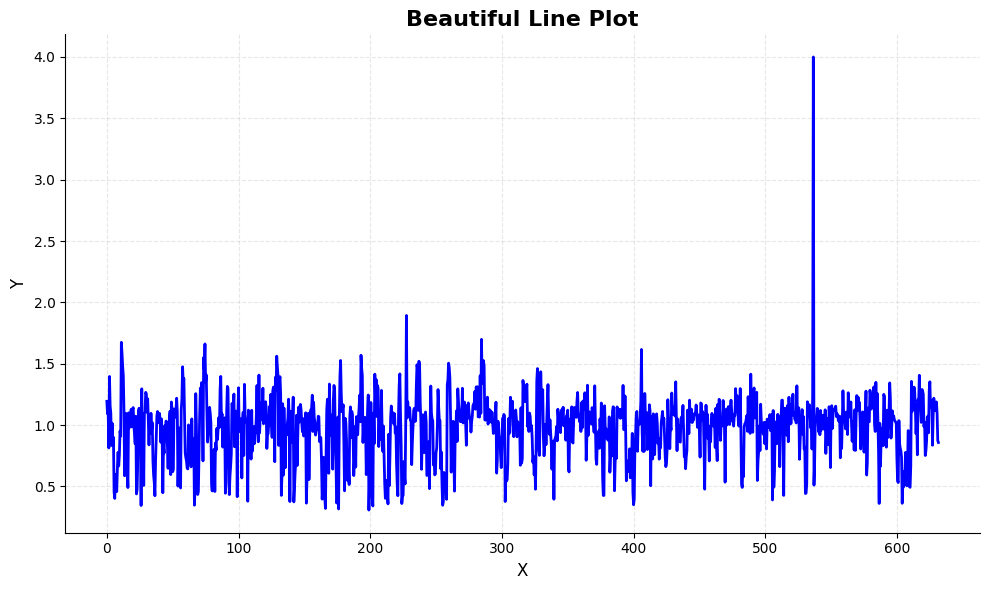

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Beautiful Line Plot'}, xlabel='X', ylabel='Y'>)

In [83]:
plot_beautiful(x=new_df_copy['Time'], y=new_df_copy['gaze_magnitude'])

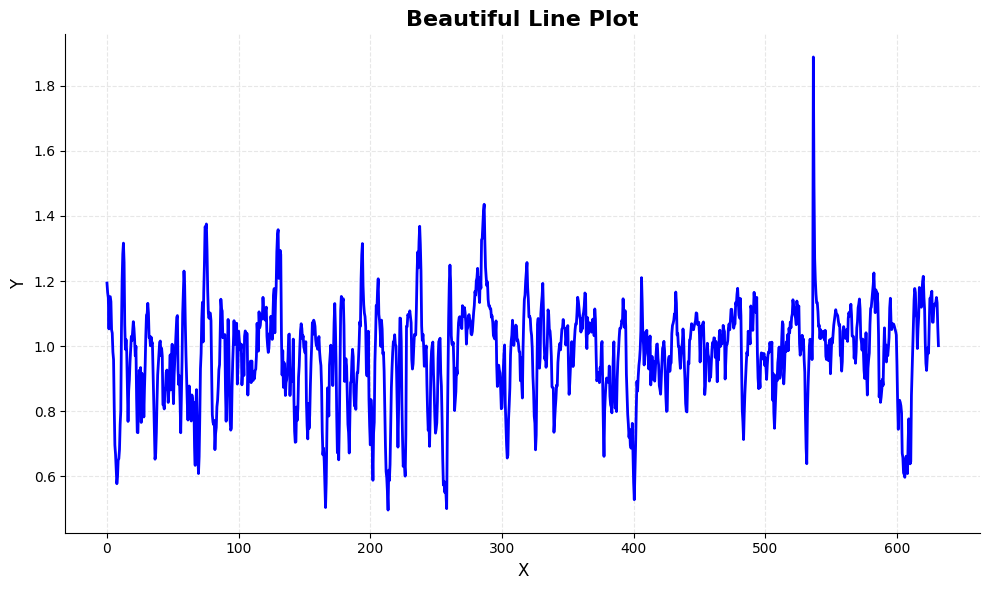

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Beautiful Line Plot'}, xlabel='X', ylabel='Y'>)

In [84]:
plot_beautiful(x=new_df_copy['Time'], y=new_df_copy['gaze_magnitude_smooth'])

In [85]:
temp = new_df_copy[new_df_copy['speaker'] == 'B']['loudness_db'].ewm(span=value, adjust=False).mean()
temp

23     -20.250000
24     -23.023333
25     -23.278148
26     -22.236337
27     -22.239374
          ...    
1190   -21.424621
1191   -19.825816
1192   -18.417857
1193   -19.060555
1194   -21.333765
Name: loudness_db, Length: 1053, dtype: float64

In [86]:
audio_spans = {
    'loudness_db': 5,
    'pitch_relative_st': 8,
    'pitch_expressiveness_st': 6,
    'wps': 6,
}
mask = new_df_copy['speaker'] == 'B'

for key, value in audio_spans.items():
    temp = new_df_copy[new_df_copy['speaker'] == 'B'][key].ewm(span=value, adjust=False).mean()
    new_df_copy.loc[temp.index, f"{key}_smooth"] = temp.values

In [87]:
new_df_copy['loudness_db_smooth']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
1259   -22.329259
1260   -22.329259
1261   -22.329259
1262   -22.329259
1263   -22.329259
Name: loudness_db_smooth, Length: 1264, dtype: float64

In [88]:
new_df_copy.columns

Index(['blink_intensity', 'gaze_magnitude', 'jaw_magnitude', 'smile_intensity',
       'loudness_db', 'pitch_relative_st', 'pitch_expressiveness_st', 'Time',
       'words', 'text_concat', 'speaker', 'filler_percentage',
       'pause_percent_pr', 'wps', 'blink_intensity_smooth',
       'gaze_magnitude_smooth', 'jaw_magnitude_smooth',
       'smile_intensity_smooth', 'loudness_db_smooth',
       'pitch_relative_st_smooth', 'pitch_expressiveness_st_smooth',
       'wps_smooth'],
      dtype='object')

In [89]:
new_df_smooth = new_df_copy[['Time', 'blink_intensity_smooth', 'gaze_magnitude_smooth', 'jaw_magnitude_smooth',
       'smile_intensity_smooth', 'loudness_db_smooth',
       'pitch_relative_st_smooth', 'pitch_expressiveness_st_smooth',
       'wps_smooth', 'words', 'text_concat', 'speaker', 'filler_percentage',
       'pause_percent_pr']]

In [90]:
new_df_smooth.head()

,Time,blink_intensity_smooth,gaze_magnitude_smooth,jaw_magnitude_smooth,smile_intensity_smooth,loudness_db_smooth,pitch_relative_st_smooth,pitch_expressiveness_st_smooth,wps_smooth,words,text_concat,speaker,filler_percentage,pause_percent_pr
0,0.0,0.559023,1.193973,0.030817,0.000201,NaN,NaN,NaN,NaN,"[We're, starting]",We're starting,None,0.064433,0.079177
1,0.5,0.384148,1.164989,0.027141,0.000202,NaN,NaN,NaN,NaN,"[now., [*]]",now. [*],A,0.064433,0.079177
2,1.0,0.341802,1.148999,0.017119,0.000171,NaN,NaN,NaN,NaN,None,,A,0.064433,0.079177
3,1.5,0.313821,1.053179,0.011451,0.000134,NaN,NaN,NaN,NaN,"[So, welcome]",So welcome,A,0.064433,0.079177
4,2.0,0.344163,1.151186,0.007192,0.000114,NaN,NaN,NaN,NaN,"[to, the]",to the,A,0.064433,0.079177


In [112]:
(new_df_smooth[['loudness_db']][(new_df_smooth['speaker'] == 'A') | (new_df_smooth['speaker'] == None)]).isna().all()

KeyError: "None of [Index(['loudness_db'], dtype='object')] are in the [columns]"